# Random Dataset Generation with Equal Fragment Type Distribution

This notebook generates train/val/test datasets with configurable fragment type distributions.
Each fragment is paired with its complete original sequence for binary classification.

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Configuration Parameters

Configure the percentage of each fragment type in the dataset.
The percentages should sum to 100.

In [3]:
# Fragment type distribution (percentages, should sum to 100)
FRAGMENT_DISTRIBUTION = {
    'terminal_N': 20.0,
    'terminal_C': 20.0,
    'terminal_both': 20.0,
    'internal_gap': 20.0,
    'mixed': 20.0
}

# Verify distribution sums to 100
total_pct = sum(FRAGMENT_DISTRIBUTION.values())
assert abs(total_pct - 100.0) < 0.01, f"Fragment percentages must sum to 100, got {total_pct}"

# Total number of fragments to generate per split
TARGET_FRAGMENTS = {
    'train': 45264,
    'val': 11316,
    'test': 14146
}

# Minimum fragment length
MIN_FRAGMENT_LENGTH = 10

# Data paths
DATA_DIR = Path('../data')
OUTPUT_DIR = Path('../datasets/random_equal_distribution2')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Configuration:")
print(f"Fragment type distribution: {FRAGMENT_DISTRIBUTION}")
print(f"Target fragments: {TARGET_FRAGMENTS}")
print(f"Minimum fragment length: {MIN_FRAGMENT_LENGTH}")
print(f"Output directory: {OUTPUT_DIR}")

Configuration:
Fragment type distribution: {'terminal_N': 20.0, 'terminal_C': 20.0, 'terminal_both': 20.0, 'internal_gap': 20.0, 'mixed': 20.0}
Target fragments: {'train': 45264, 'val': 11316, 'test': 14146}
Minimum fragment length: 10
Output directory: ..\datasets\random_equal_distribution2


## 2. Fragment Generation Functions

Functions to generate each fragment type randomly.

In [4]:
def generate_terminal_n_fragment(sequence: str) -> Optional[Tuple[str, str]]:
    """
    Generate N-terminal fragment by removing C-terminal portion.
    Returns (fragment_sequence, fragment_type) or None if not possible.
    """
    seq_length = len(sequence)
    if seq_length < MIN_FRAGMENT_LENGTH + 10:
        return None
    
    # Remove between 10% and 50% from C-terminus
    min_removal = max(10, int(seq_length * 0.1))
    max_removal = min(seq_length - MIN_FRAGMENT_LENGTH, int(seq_length * 0.5))
    
    if min_removal >= max_removal:
        return None
    
    removal_point = np.random.randint(min_removal, max_removal)
    fragment = sequence[:-removal_point]
    
    if len(fragment) < MIN_FRAGMENT_LENGTH:
        return None
    
    return fragment, 'terminal_N'


def generate_terminal_c_fragment(sequence: str) -> Optional[Tuple[str, str]]:
    """
    Generate C-terminal fragment by removing N-terminal portion.
    Returns (fragment_sequence, fragment_type) or None if not possible.
    """
    seq_length = len(sequence)
    if seq_length < MIN_FRAGMENT_LENGTH + 10:
        return None
    
    # Remove between 10% and 50% from N-terminus
    min_removal = max(10, int(seq_length * 0.1))
    max_removal = min(seq_length - MIN_FRAGMENT_LENGTH, int(seq_length * 0.5))
    
    if min_removal >= max_removal:
        return None
    
    removal_point = np.random.randint(min_removal, max_removal)
    fragment = sequence[removal_point:]
    
    if len(fragment) < MIN_FRAGMENT_LENGTH:
        return None
    
    return fragment, 'terminal_C'


def generate_terminal_both_fragment(sequence: str) -> Optional[Tuple[str, str]]:
    """
    Generate fragment by removing both N- and C-terminal portions.
    Returns (fragment_sequence, fragment_type) or None if not possible.
    """
    seq_length = len(sequence)
    if seq_length < MIN_FRAGMENT_LENGTH + 30:
        return None
    
    # Total removal should be 20-60% of sequence
    min_total_removal = max(20, int(seq_length * 0.2))
    max_total_removal = min(seq_length - MIN_FRAGMENT_LENGTH, int(seq_length * 0.6))
    
    if min_total_removal >= max_total_removal:
        return None
    
    total_removal = np.random.randint(min_total_removal, max_total_removal)
    
    # Split removal between N and C terminus (each gets at least 10 aa)
    min_n_removal = 10
    max_n_removal = total_removal - 10
    
    if min_n_removal >= max_n_removal:
        return None
    
    n_removal = np.random.randint(min_n_removal, max_n_removal)
    c_removal = total_removal - n_removal
    
    fragment = sequence[n_removal:-c_removal] if c_removal > 0 else sequence[n_removal:]
    
    if len(fragment) < MIN_FRAGMENT_LENGTH:
        return None
    
    return fragment, 'terminal_both'


def generate_internal_gap_fragment(sequence: str) -> Optional[Tuple[str, str]]:
    """
    Generate fragment with internal gap by removing a middle section.
    Returns (fragment_sequence, fragment_type) or None if not possible.
    """
    seq_length = len(sequence)
    if seq_length < MIN_FRAGMENT_LENGTH + 30:
        return None
    
    # Gap should be 10-40% of sequence length
    min_gap = max(10, int(seq_length * 0.1))
    max_gap = min(seq_length - MIN_FRAGMENT_LENGTH, int(seq_length * 0.4))
    
    if min_gap >= max_gap:
        return None
    
    gap_size = np.random.randint(min_gap, max_gap)
    
    # Gap should start between 20% and 60% of sequence
    min_gap_start = max(10, int(seq_length * 0.2))
    max_gap_start = min(seq_length - gap_size - 10, int(seq_length * 0.6))
    
    if min_gap_start >= max_gap_start:
        return None
    
    gap_start = np.random.randint(min_gap_start, max_gap_start)
    gap_end = gap_start + gap_size
    
    # Create fragment by removing the gap (concatenate parts)
    fragment = sequence[:gap_start] + sequence[gap_end:]
    
    if len(fragment) < MIN_FRAGMENT_LENGTH:
        return None
    
    return fragment, 'internal_gap'


def generate_mixed_fragment(sequence: str) -> Optional[Tuple[str, str]]:
    """
    Generate mixed fragment by removing N-terminus and creating internal gap.
    Returns (fragment_sequence, fragment_type) or None if not possible.
    """
    seq_length = len(sequence)
    if seq_length < MIN_FRAGMENT_LENGTH + 40:
        return None
    
    # Remove 10-30% from N-terminus
    min_n_removal = max(10, int(seq_length * 0.1))
    max_n_removal = min(seq_length // 3, int(seq_length * 0.3))
    
    if min_n_removal >= max_n_removal:
        return None
    
    n_removal = np.random.randint(min_n_removal, max_n_removal)
    
    # Create internal gap in remaining sequence
    remaining_seq = sequence[n_removal:]
    remaining_length = len(remaining_seq)
    
    if remaining_length < MIN_FRAGMENT_LENGTH + 20:
        return None
    
    # Gap should be 10-30% of remaining sequence
    min_gap = max(10, int(remaining_length * 0.1))
    max_gap = min(remaining_length - MIN_FRAGMENT_LENGTH, int(remaining_length * 0.3))
    
    if min_gap >= max_gap:
        return None
    
    gap_size = np.random.randint(min_gap, max_gap)
    
    # Place gap in middle portion
    min_gap_start = max(10, int(remaining_length * 0.2))
    max_gap_start = min(remaining_length - gap_size - 10, int(remaining_length * 0.6))
    
    if min_gap_start >= max_gap_start:
        return None
    
    gap_start = np.random.randint(min_gap_start, max_gap_start)
    gap_end = gap_start + gap_size
    
    # Create fragment
    fragment = remaining_seq[:gap_start] + remaining_seq[gap_end:]
    
    if len(fragment) < MIN_FRAGMENT_LENGTH:
        return None
    
    return fragment, 'mixed'


# Map fragment types to generation functions
FRAGMENT_GENERATORS = {
    'terminal_N': generate_terminal_n_fragment,
    'terminal_C': generate_terminal_c_fragment,
    'terminal_both': generate_terminal_both_fragment,
    'internal_gap': generate_internal_gap_fragment,
    'mixed': generate_mixed_fragment
}

print("Fragment generation functions defined.")

Fragment generation functions defined.


## 3. Dataset Generation Function

In [5]:
def generate_dataset(split: str, target_count: int, fragment_dist: Dict[str, float]) -> pd.DataFrame:
    """
    Generate dataset for a given split (train/val/test).
    
    Args:
        split: 'train', 'val', or 'test'
        target_count: Total number of fragments to generate
        fragment_dist: Dictionary of fragment type percentages
    
    Returns:
        DataFrame with fragments and complete sequences
    """
    print(f"\n{'='*60}")
    print(f"Generating {split} dataset")
    print(f"{'='*60}")
    
    # Load protein data
    csv_path = DATA_DIR / f'swissprot_proteins_processed_{split}.csv'
    print(f"Loading proteins from {csv_path}")
    proteins_df = pd.read_csv(csv_path)
    print(f"Loaded {len(proteins_df)} proteins")
    
    # Calculate target counts for each fragment type
    fragment_targets = {}
    for frag_type, pct in fragment_dist.items():
        fragment_targets[frag_type] = int(target_count * pct / 100)
    
    print(f"\nTarget fragment counts:")
    for frag_type, count in fragment_targets.items():
        print(f"  {frag_type}: {count}")
    
    # Storage for generated data
    all_records = []
    fragment_counts = {frag_type: 0 for frag_type in fragment_dist.keys()}
    
    # Generate fragments
    total_attempts = 0
    max_attempts = target_count * 10  # Prevent infinite loops
    
    # Shuffle proteins for random selection
    protein_pool = proteins_df.sample(frac=1.0, random_state=42).reset_index(drop=True)
    protein_idx = 0
    
    while any(fragment_counts[ft] < fragment_targets[ft] for ft in fragment_dist.keys()):
        if total_attempts >= max_attempts:
            print(f"\nWarning: Reached maximum attempts ({max_attempts})")
            break
        
        total_attempts += 1
        
        # Get next protein (cycle through if needed)
        if protein_idx >= len(protein_pool):
            protein_pool = proteins_df.sample(frac=1.0).reset_index(drop=True)
            protein_idx = 0
        
        protein = protein_pool.iloc[protein_idx]
        protein_idx += 1
        
        acc_id = protein['acc_id']
        sequence = protein['sequence']
        
        # Skip if sequence too short
        if len(sequence) < MIN_FRAGMENT_LENGTH + 20:
            continue
        
        # Find which fragment types still need more samples
        needed_types = [ft for ft in fragment_dist.keys() 
                       if fragment_counts[ft] < fragment_targets[ft]]
        
        if not needed_types:
            break
        
        # Randomly select a fragment type that needs more samples
        frag_type = np.random.choice(needed_types)
        
        # Try to generate fragment
        generator = FRAGMENT_GENERATORS[frag_type]
        result = generator(sequence)
        
        if result is None:
            continue
        
        fragment, actual_type = result
        
        # Add fragment record
        all_records.append({
            'source_accession': acc_id,
            'fragment_type': actual_type,
            'sequence': fragment,
            'is_fragment': True,
            'fragment_length': len(fragment),
            'source_length': len(sequence)
        })
        
        # Add corresponding complete sequence
        all_records.append({
            'source_accession': acc_id,
            'fragment_type': 'complete',
            'sequence': sequence,
            'is_fragment': False,
            'fragment_length': len(sequence),
            'source_length': len(sequence)
        })
        
        fragment_counts[actual_type] += 1
        
        # Progress update
        if len(all_records) % 10000 == 0:
            print(f"\rGenerated {len(all_records)//2} fragment pairs...", end='')
    
    print(f"\nGeneration complete!")
    print(f"Total attempts: {total_attempts}")
    print(f"\nFinal fragment counts:")
    for frag_type, count in fragment_counts.items():
        target = fragment_targets[frag_type]
        print(f"  {frag_type}: {count}/{target} ({100*count/target:.1f}%)")
    
    # Create DataFrame
    df = pd.DataFrame(all_records)
    
    # Shuffle the dataset
    df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
    
    print(f"\nFinal dataset size: {len(df)} records")
    print(f"  Fragments: {df['is_fragment'].sum()}")
    print(f"  Complete: {(~df['is_fragment']).sum()}")
    
    return df

print("Dataset generation function defined.")

Dataset generation function defined.


## 4. Generate All Datasets

In [6]:
# Generate datasets for all splits
datasets = {}

for split in ['train', 'val', 'test']:
    datasets[split] = generate_dataset(
        split=split,
        target_count=TARGET_FRAGMENTS[split],
        fragment_dist=FRAGMENT_DISTRIBUTION
    )

print("\n" + "="*60)
print("All datasets generated successfully!")
print("="*60)


Generating train dataset
Loading proteins from ..\data\swissprot_proteins_processed_train.csv
Loaded 239300 proteins

Target fragment counts:
  terminal_N: 9052
  terminal_C: 9052
  terminal_both: 9052
  internal_gap: 9052
  mixed: 9052
Generated 45000 fragment pairs...
Generation complete!
Total attempts: 45723

Final fragment counts:
  terminal_N: 9052/9052 (100.0%)
  terminal_C: 9052/9052 (100.0%)
  terminal_both: 9052/9052 (100.0%)
  internal_gap: 9052/9052 (100.0%)
  mixed: 9052/9052 (100.0%)

Final dataset size: 90520 records
  Fragments: 45260
  Complete: 45260

Generating val dataset
Loading proteins from ..\data\swissprot_proteins_processed_val.csv
Loaded 59857 proteins

Target fragment counts:
  terminal_N: 2263
  terminal_C: 2263
  terminal_both: 2263
  internal_gap: 2263
  mixed: 2263
Generated 10000 fragment pairs...
Generation complete!
Total attempts: 11443

Final fragment counts:
  terminal_N: 2263/2263 (100.0%)
  terminal_C: 2263/2263 (100.0%)
  terminal_both: 2263/22

## 5. Save Datasets

In [7]:
# Save each split to CSV
for split, df in datasets.items():
    output_path = OUTPUT_DIR / f'random_equal30_{split}.csv'
    df.to_csv(output_path, index=False)
    print(f"Saved {split} dataset to {output_path}")
    print(f"  Size: {len(df)} records")

print("\nAll datasets saved successfully!")

Saved train dataset to ..\datasets\random_equal_distribution2\random_equal30_train.csv
  Size: 90520 records
Saved val dataset to ..\datasets\random_equal_distribution2\random_equal30_val.csv
  Size: 22630 records
Saved test dataset to ..\datasets\random_equal_distribution2\random_equal30_test.csv
  Size: 28290 records

All datasets saved successfully!


## 6. Dataset Statistics and Validation

In [8]:
# Analyze each split
for split, df in datasets.items():
    print(f"\n{'='*60}")
    print(f"{split.upper()} Dataset Statistics")
    print(f"{'='*60}")
    
    print(f"\nTotal records: {len(df)}")
    print(f"Fragments: {df['is_fragment'].sum()}")
    print(f"Complete: {(~df['is_fragment']).sum()}")
    
    # Fragment type distribution
    print(f"\nFragment type distribution:")
    fragments_only = df[df['is_fragment']]
    type_counts = fragments_only['fragment_type'].value_counts()
    for frag_type, count in type_counts.items():
        pct = 100 * count / len(fragments_only)
        print(f"  {frag_type}: {count} ({pct:.1f}%)")
    
    # Length statistics
    print(f"\nLength statistics (fragments only):")
    for frag_type in FRAGMENT_DISTRIBUTION.keys():
        type_df = fragments_only[fragments_only['fragment_type'] == frag_type]
        if len(type_df) > 0:
            print(f"  {frag_type}:")
            print(f"    Mean: {type_df['fragment_length'].mean():.1f}")
            print(f"    Median: {type_df['fragment_length'].median():.1f}")
            print(f"    Std: {type_df['fragment_length'].std():.1f}")
            print(f"    Min: {type_df['fragment_length'].min()}")
            print(f"    Max: {type_df['fragment_length'].max()}")


TRAIN Dataset Statistics

Total records: 90520
Fragments: 45260
Complete: 45260

Fragment type distribution:
  mixed: 9052 (20.0%)
  terminal_both: 9052 (20.0%)
  terminal_C: 9052 (20.0%)
  terminal_N: 9052 (20.0%)
  internal_gap: 9052 (20.0%)

Length statistics (fragments only):
  terminal_N:
    Mean: 270.0
    Median: 213.0
    Std: 248.2
    Min: 17
    Max: 4392
  terminal_C:
    Mean: 271.1
    Median: 214.0
    Std: 265.2
    Min: 16
    Max: 6751
  terminal_both:
    Mean: 232.9
    Median: 183.0
    Std: 212.6
    Min: 18
    Max: 5333
  internal_gap:
    Mean: 295.2
    Median: 231.0
    Std: 266.8
    Min: 26
    Max: 6428
  mixed:
    Mean: 247.0
    Median: 197.0
    Std: 226.9
    Min: 27
    Max: 6546

VAL Dataset Statistics

Total records: 22630
Fragments: 11315
Complete: 11315

Fragment type distribution:
  terminal_N: 2263 (20.0%)
  terminal_both: 2263 (20.0%)
  internal_gap: 2263 (20.0%)
  mixed: 2263 (20.0%)
  terminal_C: 2263 (20.0%)

Length statistics (fragments 

## 7. Visualization

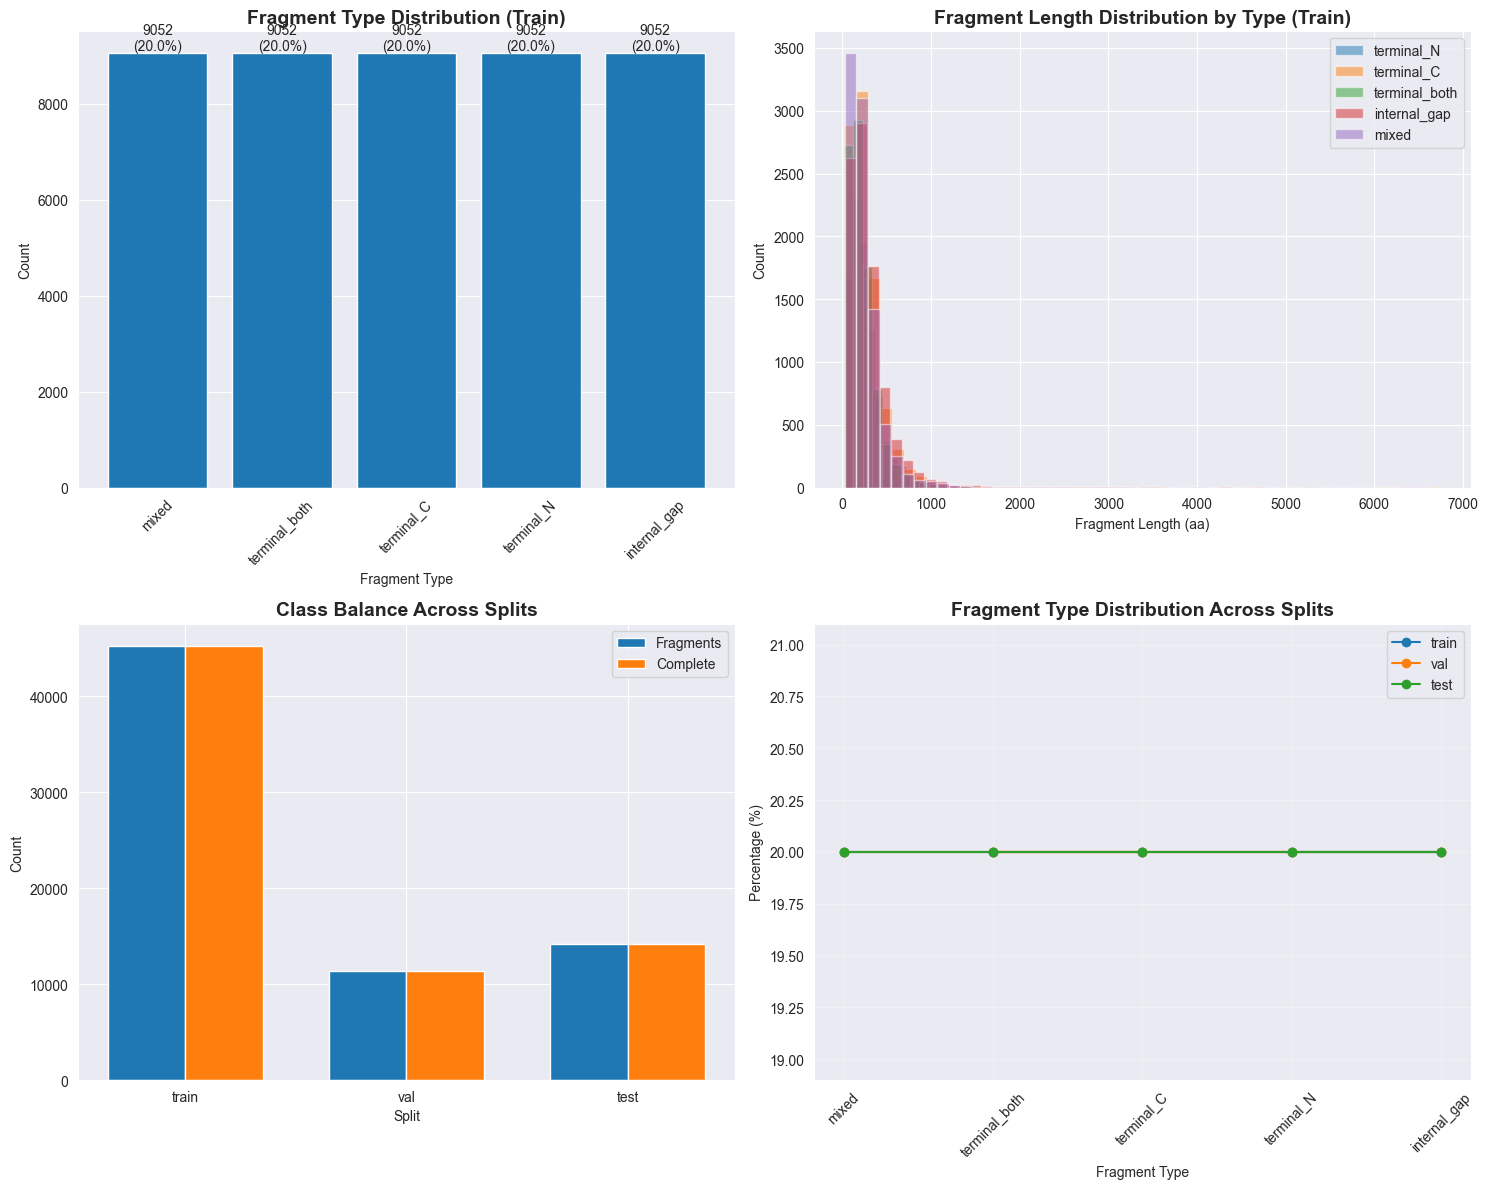


Visualization saved to ..\datasets\random_equal_distribution2\dataset_statistics.png


In [9]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Fragment type distribution (train set)
train_fragments = datasets['train'][datasets['train']['is_fragment']]
type_counts = train_fragments['fragment_type'].value_counts()
axes[0, 0].bar(type_counts.index, type_counts.values)
axes[0, 0].set_title('Fragment Type Distribution (Train)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Fragment Type')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, (idx, val) in enumerate(type_counts.items()):
    axes[0, 0].text(i, val, f'{val}\n({100*val/len(train_fragments):.1f}%)', 
                    ha='center', va='bottom')

# 2. Fragment length distribution by type (train set)
for frag_type in FRAGMENT_DISTRIBUTION.keys():
    type_df = train_fragments[train_fragments['fragment_type'] == frag_type]
    if len(type_df) > 0:
        axes[0, 1].hist(type_df['fragment_length'], bins=50, alpha=0.5, label=frag_type)
axes[0, 1].set_title('Fragment Length Distribution by Type (Train)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Fragment Length (aa)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend()

# 3. Class balance across splits
split_stats = []
for split in ['train', 'val', 'test']:
    df = datasets[split]
    split_stats.append({
        'Split': split,
        'Fragments': df['is_fragment'].sum(),
        'Complete': (~df['is_fragment']).sum()
    })
split_stats_df = pd.DataFrame(split_stats)
x = np.arange(len(split_stats_df))
width = 0.35
axes[1, 0].bar(x - width/2, split_stats_df['Fragments'], width, label='Fragments')
axes[1, 0].bar(x + width/2, split_stats_df['Complete'], width, label='Complete')
axes[1, 0].set_title('Class Balance Across Splits', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Split')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(split_stats_df['Split'])
axes[1, 0].legend()

# 4. Fragment type distribution across splits
for split in ['train', 'val', 'test']:
    split_fragments = datasets[split][datasets[split]['is_fragment']]
    type_pcts = split_fragments['fragment_type'].value_counts(normalize=True) * 100
    axes[1, 1].plot(type_pcts.index, type_pcts.values, marker='o', label=split)
axes[1, 1].set_title('Fragment Type Distribution Across Splits', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Fragment Type')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'dataset_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to {OUTPUT_DIR / 'dataset_statistics.png'}")

## 8. Generate Summary Report

In [ ]:
# Create summary report
summary_lines = []
summary_lines.append("# Random Equal Distribution Dataset Summary\n")
summary_lines.append(f"Generated: {pd.Timestamp.now()}\n\n")

summary_lines.append("## Configuration\n")
summary_lines.append("Fragment Type Distribution:\n")
for frag_type, pct in FRAGMENT_DISTRIBUTION.items():
    summary_lines.append(f"- {frag_type}: {pct}%\n")
summary_lines.append(f"\nMinimum fragment length: {MIN_FRAGMENT_LENGTH} aa\n\n")

summary_lines.append("## Dataset Sizes\n")
for split in ['train', 'val', 'test']:
    df = datasets[split]
    summary_lines.append(f"\n### {split.capitalize()}\n")
    summary_lines.append(f"- Total records: {len(df)}\n")
    summary_lines.append(f"- Fragments: {df['is_fragment'].sum()}\n")
    summary_lines.append(f"- Complete sequences: {(~df['is_fragment']).sum()}\n")
    
    fragments = df[df['is_fragment']]
    summary_lines.append(f"\nFragment type counts:\n")
    for frag_type, count in fragments['fragment_type'].value_counts().items():
        pct = 100 * count / len(fragments)
        summary_lines.append(f"- {frag_type}: {count} ({pct:.1f}%)\n")

summary_lines.append("\n## Output Files\n")
summary_lines.append(f"- {OUTPUT_DIR / 'random_equal_train.csv'}\n")
summary_lines.append(f"- {OUTPUT_DIR / 'random_equal_val.csv'}\n")
summary_lines.append(f"- {OUTPUT_DIR / 'random_equal_test.csv'}\n")
summary_lines.append(f"- {OUTPUT_DIR / 'dataset_statistics.png'}\n")

# Save summary
summary_path = OUTPUT_DIR / 'DATASET_SUMMARY.md'
with open(summary_path, 'w') as f:
    f.writelines(summary_lines)

print(f"\nSummary report saved to {summary_path}")
print("\n" + "="*60)
print("Dataset generation complete!")
print("="*60)